In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# check pytorch  version
torch.__version__

'2.9.0+cpu'

In [2]:
# create "known" parameters
weight = 0.7
bias = 0.3

# create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [3]:
# create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing.
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train),len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [4]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    """plots training data, test data and compares predictions.

    Args:
        train_data (_type_, optional): _description_. Defaults to X_train.
        train_labels (_type_, optional): _description_. Defaults to y_train.
        test_data (_type_, optional): _description_. Defaults to X_test.
        test_labels (_type_, optional): _description_. Defaults to y_test.
        predictions (_type_, optional): _description_. Defaults to None.
    """
    plt.figure(figsize=(20, 7))
    
    # plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    
    #plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")
    
    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label= "Predictions")
        
        # Show the legend
        plt.legend(prop={"size": 14});
        

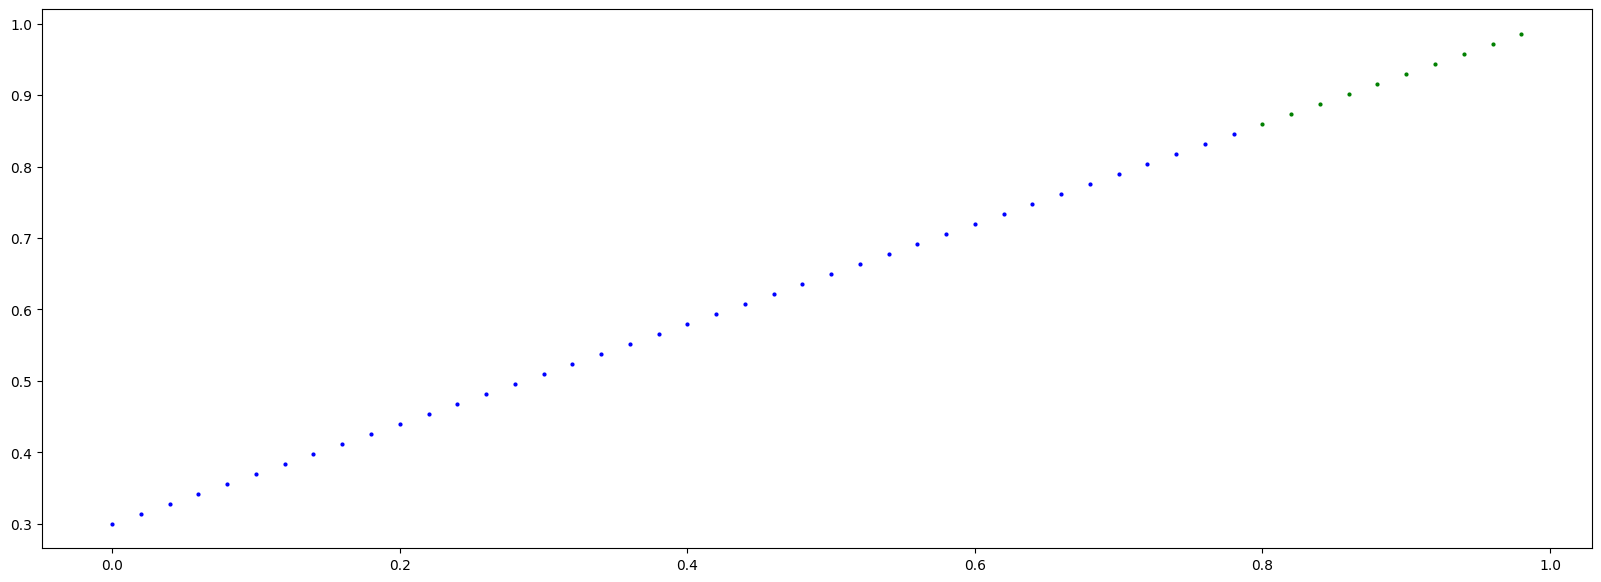

In [5]:
plot_predictions();

In [6]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in pytorch is a nn.Module(think of this as neural network lego blocks)
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1,))